<a href="https://colab.research.google.com/github/henrykhlai/LSTM-rescale-precidtion/blob/main/LSTM_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
pip install yfinance

     |████████████████████████████████| 6.3MB 8.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=c980425868e970684c91aa0bb277c5a7b3e5d35a661444cbcdb0b04f11f2db46
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
raw_data = yfinance.download(tickers ="aapl", start="2010-01-01",end="2021-5-10",
                             interval="1d",group_by='ticker',auto_adjust=True, treads=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
data = raw_data['Close'].values

In [ ]:
timeseries_data = data[:-20]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

# scale and revert scale of input
def rescale(x,a,b):
    z = (x-a)/(b-a)
    return z

def revertscale(z,a,b):
    x = z*(b-a)+a
    return x

# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
    X, y =[],[]
    for i in range(len(timeseries_data)-n_features):        
        # find the end of this pattern
        end_ix = i + n_features
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def LSTM_predict(timeseries_data, n_steps, n_features=1, predict_steps=20):
    
    # split into samples
    X, y = prepare_data(timeseries_data, n_steps)

    # reshape from [samples, timesteps] into [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(X, y, epochs=200, verbose=0) # vervose = 0 make training Epoch not show

    # Prediction
    x_input = []
    x_input = timeseries_data[-(n_steps):]
    
    '''for i in range(n_steps,0,-1):
        x_input.append(timeseries_data[-i])
    x_input = np.array(x_input) # matrix'''

    x_input = x_input.reshape((1, n_steps, n_features)) # tensor
    yhat = model.predict(x_input, verbose=0)


    predict_output = []
    predict_output.append(yhat)
    x_input = x_input[0]

    xx_input = np.append(x_input[-(n_steps-1):],yhat[0])
    xx_input = xx_input.reshape(n_steps,n_features) #matrix
    #xx_input = np.array([x_input[-2],x_input[-1],yhat[0]]) # matrix
    #print(xx_input.shape)

    for i in range(predict_steps):
        xx_input = xx_input.reshape((1, n_steps, n_features)) # tensor
        # LSTM model only accept tensor as input
        yhat = model.predict(xx_input, verbose=0)

        xx_input = xx_input[0]

        xx_input = np.append(xx_input[-(n_steps-1):],yhat[0])
        xx_input = xx_input.reshape(n_steps,n_features) #matrix

        predict_output.append(yhat[0,0])

    predict_output = np.array(predict_output, dtype=np.float32)
    return predict_output

In [ ]:
# define input sequence
timeseries_data = data[:-20]
a = np.min(timeseries_data)
b = np.max(timeseries_data)
date_ahead = 5
XX = rescale(timeseries_data,a,b)
yy = LSTM_predict(XX, 25,1,date_ahead)
predict_output = revertscale(yy,a,b)

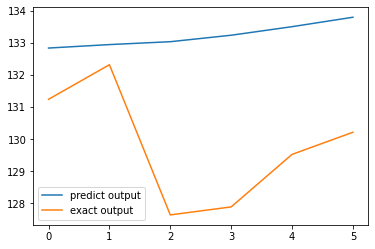

% error:
 [1.21776533 0.47450173 4.23071982 4.18508025 3.07394139 2.75361305]


In [ ]:
import matplotlib.pyplot as plt
exact_output = timeseries_data = data[-date_ahead-1:]
plt.plot(predict_output, label ='predict output')
plt.plot(exact_output, label = 'exact output')
plt.legend()
plt.show()    
print('% error:\n', (predict_output - exact_output)/exact_output * 100) 

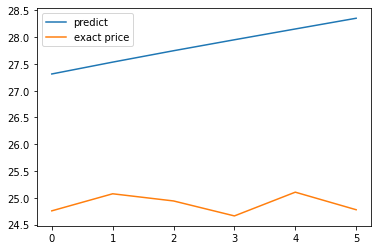

In [ ]:
plt.plot(predict_output,label='predict')
plt.plot(timeseries_data, label='exact price')
plt.legend()
plt.show()
